In [1]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_predict, LeaveOneOut
import os
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

AttributeError: _ARRAY_API not found

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'PCA_Keitt'

file_path_raw_cal = base_path / 'RAW_calibration.xlsx'
file_path_msc_cal = base_path / 'MSC_calibration.xlsx'
file_path_snv_cal = base_path / 'SNV_calibration.xlsx'
file_path_sg_cal = base_path / 'SG_calibration.xlsx'

df_raw_cal = pd.read_excel(file_path_raw_cal)
df_msc_cal = pd.read_excel(file_path_msc_cal)
df_snv_cal = pd.read_excel(file_path_snv_cal)
df_sg_cal = pd.read_excel(file_path_sg_cal)

file_path_raw_val = base_path / 'RAW_validation.xlsx'
file_path_msc_val = base_path / 'MSC_validation.xlsx'
file_path_snv_val = base_path / 'SNV_validation.xlsx'
file_path_sg_val = base_path / 'SG_validation.xlsx'

df_raw_val = pd.read_excel(file_path_raw_val)
df_msc_val = pd.read_excel(file_path_msc_val)
df_snv_val = pd.read_excel(file_path_snv_val)
df_sg_val = pd.read_excel(file_path_sg_val)

In [3]:
def SVM(X_cal, y_cal, X_val, y_val, filter, attribute):
    # Função para calcular as métricas
    def calculate_metrics(y_true, y_pred):
        model = LinearRegression().fit(y_pred.reshape(-1, 1), y_true)
        slope = model.coef_[0]
        offset = model.intercept_
        r2 = r2_score(y_true, y_pred)
        correlation_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mean_y_true = np.mean(y_true)
        relative_absolute_error = 100 * (mae / np.mean(np.abs(y_true - mean_y_true)))
        root_relative_squared_error = 100 * (rmse / np.std(y_true))

        return {
            "R²": r2,
            "Correlation coefficient": correlation_coefficient,
            "RMSE": rmse,
            "MAE": mae,
            "Relative absolute error": relative_absolute_error,
            "Root relative squared error": root_relative_squared_error,
            "Slope": slope,
            "Offset": offset
        }
    def display_metrics(title, metrics):
        print(f"=== {title} ===")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    # Definir variáveis de treino e teste para o atributo atual
    X_train, y_train = X_cal, y_cal
    X_test, y_test = X_val, y_val
    # Criar o pipeline
    pipeline = make_pipeline(
        StandardScaler(),  # Normalização dos dados
        SVR(
            C=4,                # Complexidade do modelo
            epsilon=0.001,        # Epsilon para a perda insensível
            gamma=0.000465,     # Gamma do kernel (inverso do cacheSize em Weka)
            tol=0.0001,            # Tolerância para critério de parada
            cache_size=250007,    # Tamanho do cache
            verbose=False,        # Não exibir mensagens detalhadas
            max_iter=5000
    ))

    # Treinar o modelo
    pipeline.fit(X_train, y_train)

    # Fazer previsões no conjunto de treinamento
    y_train_pred = pipeline.predict(X_train)
    training_metrics = calculate_metrics(y_train, y_train_pred)
    display_metrics("Training Metrics", training_metrics)

    # Validação cruzada Leave-One-Out (LOO)
    loo = LeaveOneOut()
    y_train_cv = cross_val_predict(pipeline, X_train, y_train, cv=loo)
    cv_metrics = calculate_metrics(y_train, y_train_cv)
    display_metrics("Cross-Validation Metrics", cv_metrics)

    # Avaliação final no conjunto de teste
    y_pred_val = pipeline.predict(X_test)
    validation_metrics = calculate_metrics(y_test, y_pred_val)
    display_metrics("Validation Metrics", validation_metrics)

    results_df = pd.DataFrame({
        "Attribute": [attribute, attribute, attribute],
        "Y": ["Training", "Cross-Validation", "Validation"],
        "R²": [training_metrics["R²"], cv_metrics["R²"], validation_metrics["R²"]],
        "Correlation coefficient": [training_metrics["Correlation coefficient"], cv_metrics["Correlation coefficient"], validation_metrics["Correlation coefficient"]],
        "RMSE": [training_metrics["RMSE"], cv_metrics["RMSE"], validation_metrics["RMSE"]],
        "MAE": [training_metrics["MAE"], cv_metrics["MAE"], validation_metrics["MAE"]],
        "Relative absolute error": [training_metrics["Relative absolute error"], cv_metrics["Relative absolute error"], validation_metrics["Relative absolute error"]],
        "Root relative squared error": [training_metrics["Root relative squared error"], cv_metrics["Root relative squared error"], validation_metrics["Root relative squared error"]],
        "Slope": [training_metrics["Slope"], cv_metrics["Slope"], validation_metrics["Slope"]],
        "Offset": [training_metrics["Offset"], cv_metrics["Offset"], validation_metrics["Offset"]]
    })
    
    def plot_regression_comparison(y_train, y_pred_train, y_pred_cv):    
        slope_pred, offset_pred = np.polyfit(y_train, y_pred_train, 1)
        rmse_pred = np.sqrt(mean_squared_error(y_train, y_pred_train))
        r2_pred = r2_score(y_train, y_pred_train)
        
        slope_opt, offset_opt = np.polyfit(y_train, y_pred_cv, 1)
        rmse_opt = np.sqrt(mean_squared_error(y_train, y_pred_cv))
        r2_opt = r2_score(y_train, y_pred_cv)
        
        metrics_dict = pd.DataFrame({
        'Y': ['Referência', 'Predição'],
        'Slope': [slope_opt,slope_pred],
        'Offset': [offset_opt, offset_pred],
        'RMSE': [rmse_opt, rmse_pred],
        'R²': [r2_opt, r2_pred]
        })
        
        plt.figure(figsize=(10, 6))
        
        # Scatter plot for reference values
        plt.scatter(y_train, y_pred_cv, color='blue', label='Referência', marker='o', alpha=0.7)

    # Adicionar linha de calibração para os valores otimizados (y_pred_cv)
        plt.plot(y_train, slope_opt * y_train + offset_opt, color='blue', linestyle='--', label=f'Calibração (Slope={slope_opt:.2f}, Offset={offset_opt:.2f})')

    # Adicionar linha de calibração para os valores preditos (y_pred_train)
        plt.plot(y_train, slope_pred * y_train + offset_pred, color='red', linestyle='--', label=f'Predição (Slope={slope_pred:.2f}, Offset={offset_pred:.2f})')

    # Scatter plot para os valores preditos (y_pred_train)
        plt.scatter(y_train, y_pred_train, color='red', label='Predito', marker='o', alpha=0.7)
        
        plt.xlabel("Reference")
        plt.ylabel("Predicted")
        plt.title(f"{filter + " - " + attribute}: Reference vs. Predicted")
        plt.grid(True)
        plt.text(0.05, 0.95, f'Predicted - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nReference - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
                transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
        plt.legend(loc='lower right')
        plt.show()

    # Plotar comparação entre valores reais e preditos
    plot_regression_comparison(y_train, y_train_pred, y_train_cv)
    
    def plot_test_predictions(y_true_test, y_pred_test):
        # Calcular slope, offset, R² e RMSE
        model = LinearRegression().fit(y_pred_test.reshape(-1, 1), y_true_test)
        slope = model.coef_[0]
        offset = model.intercept_
        y_pred_line = model.predict(np.array([y_true_test.min(), y_true_test.max()]).reshape(-1, 1))
        r2 = r2_score(y_true_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_test, y_true_test, color='green', label='Dados')
        plt.plot([y_true_test.min(), y_true_test.max()], y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.title('Predições no Conjunto de Teste')
        plt.legend()
        plt.text(0.05, 0.95, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
                transform=plt.gca().transAxes, verticalalignment='top')
        plt.tight_layout()
        plt.show()

    # Plotar as predições do conjunto de teste
    plot_test_predictions(y_test, y_pred_val)
    
    return results_df

In [4]:
infos_msc = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])
infos_snv = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])
infos_sg = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])

def add_plot_infos(plot_infos_pre, plot_infos_df, attribute):
    # Cria uma cópia do DataFrame para evitar alterações no original
    plot_infos_df = plot_infos_df.copy()
    
    # Adiciona a coluna 'Attribute' ao DataFrame plot_infos_df
    plot_infos_df['Attribute'] = attribute
    
    # Adiciona a nova linha ao DataFrame existente
    plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)
    
    return plot_infos_pre

=== Training Metrics ===
R²: 0.2294
Correlation coefficient: 0.5238
RMSE: 1.5090
MAE: 0.9567
Relative absolute error: 72.5161
Root relative squared error: 87.7850
Slope: 1.2468
Offset: -2.9561
=== Cross-Validation Metrics ===
R²: -0.0583
Correlation coefficient: 0.1505
RMSE: 1.7684
MAE: 1.3816
Relative absolute error: 104.7260
Root relative squared error: 102.8748
Slope: 0.3671
Offset: 6.4888
=== Validation Metrics ===
R²: 0.3417
Correlation coefficient: 0.6000
RMSE: 0.5354
MAE: 0.4655
Relative absolute error: 77.4232
Root relative squared error: 81.1365
Slope: 0.8664
Offset: 1.3818


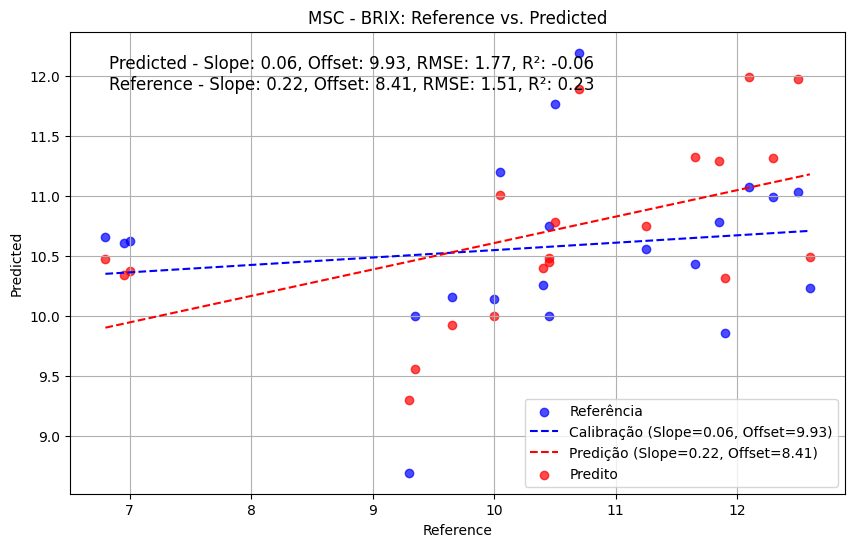

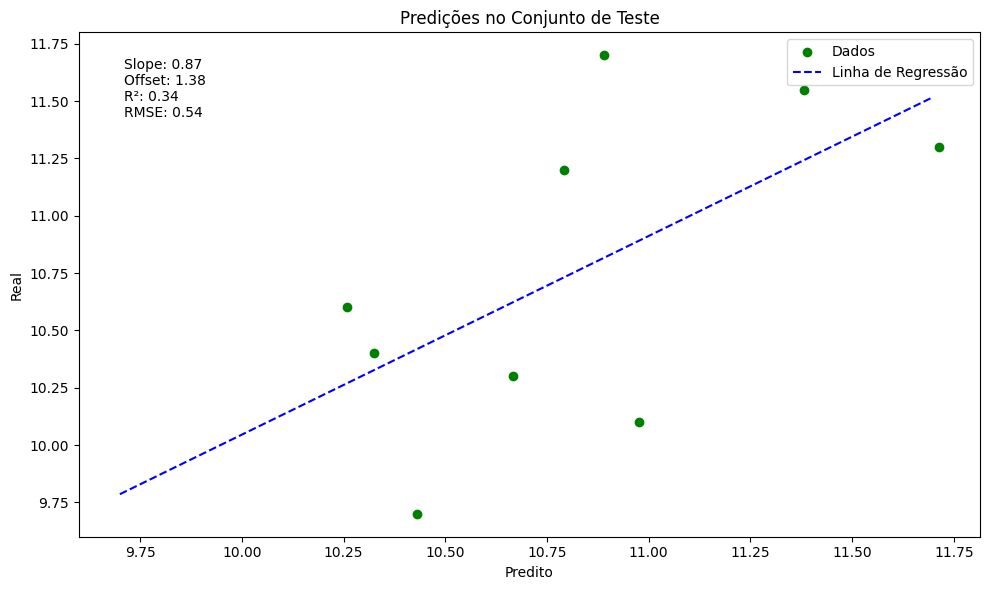

C:\Users\lenau\AppData\Local\Temp\ipykernel_9300\2636434218.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)


In [5]:
results_msc_sst = SVM(df_msc_cal.iloc[:, 7:], df_msc_cal['BRIX'].values, df_msc_val.iloc[:, 7:], df_msc_val['BRIX'].values, 'MSC', 'BRIX')
infos_msc = add_plot_infos(infos_msc, results_msc_sst, 'BRIX')

=== Training Metrics ===
R²: -0.3211
Correlation coefficient: 0.8399
RMSE: 60.6820
MAE: 44.3635
Relative absolute error: 85.4577
Root relative squared error: 114.9378
Slope: 13.6266
Offset: -1298.5741
=== Cross-Validation Metrics ===
R²: -0.3639
Correlation coefficient: 0.6266
RMSE: 61.6583
MAE: 45.5424
Relative absolute error: 87.7287
Root relative squared error: 116.7868
Slope: 12.9831
Offset: -1234.8104
=== Validation Metrics ===
R²: -1.5527
Correlation coefficient: 0.9051
RMSE: 75.8402
MAE: 62.8052
Relative absolute error: 140.3433
Root relative squared error: 159.7708
Slope: 16.1217
Offset: -1570.1684


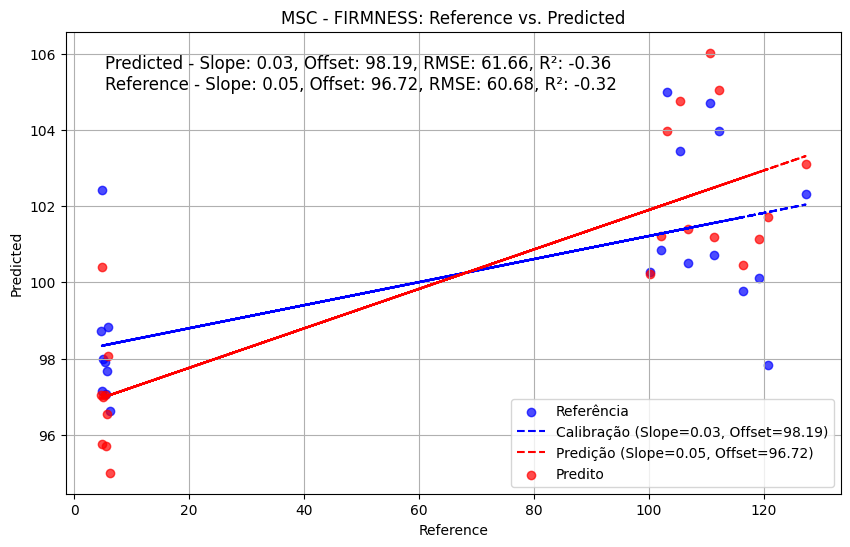

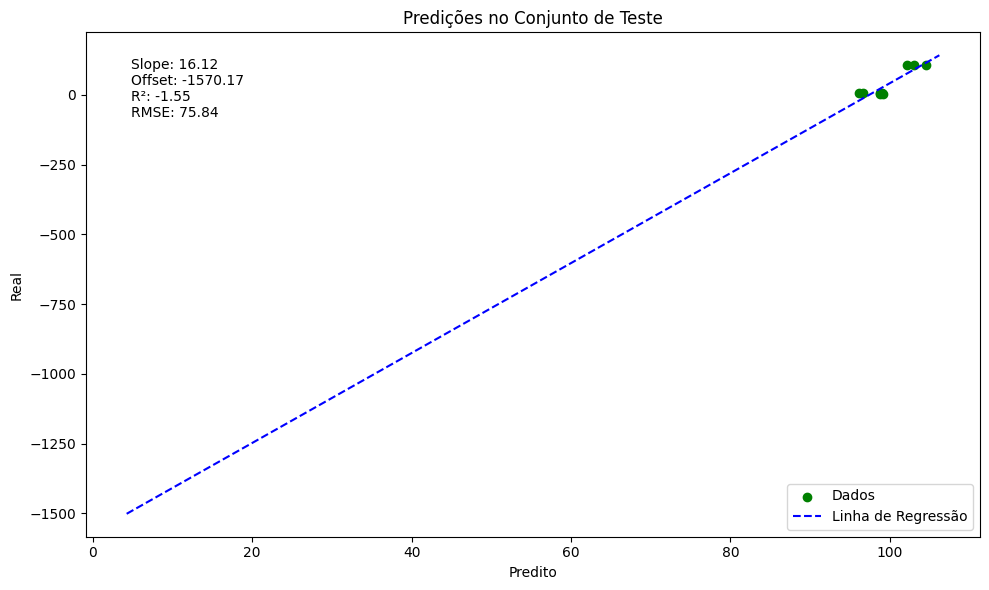

In [6]:
results_msc_sst = SVM(df_msc_cal.iloc[:, 7:], df_msc_cal['FIRMNESS'].values, df_msc_val.iloc[:, 7:], df_msc_val['FIRMNESS'].values, 'MSC', 'FIRMNESS')
infos_msc = add_plot_infos(infos_msc, results_msc_sst, 'FIRMNESS')

=== Training Metrics ===
R²: 0.5253
Correlation coefficient: 0.8095
RMSE: 4.0591
MAE: 2.9461
Relative absolute error: 57.4747
Root relative squared error: 68.8990
Slope: 1.7139
Offset: -12.4299
=== Cross-Validation Metrics ===
R²: 0.4190
Correlation coefficient: 0.7275
RMSE: 4.4906
MAE: 3.4653
Relative absolute error: 67.6017
Root relative squared error: 76.2225
Slope: 1.7316
Offset: -12.6981
=== Validation Metrics ===
R²: -0.1425
Correlation coefficient: 0.6887
RMSE: 4.4205
MAE: 3.2059
Relative absolute error: 86.5810
Root relative squared error: 106.8876
Slope: 1.2234
Offset: -6.8176


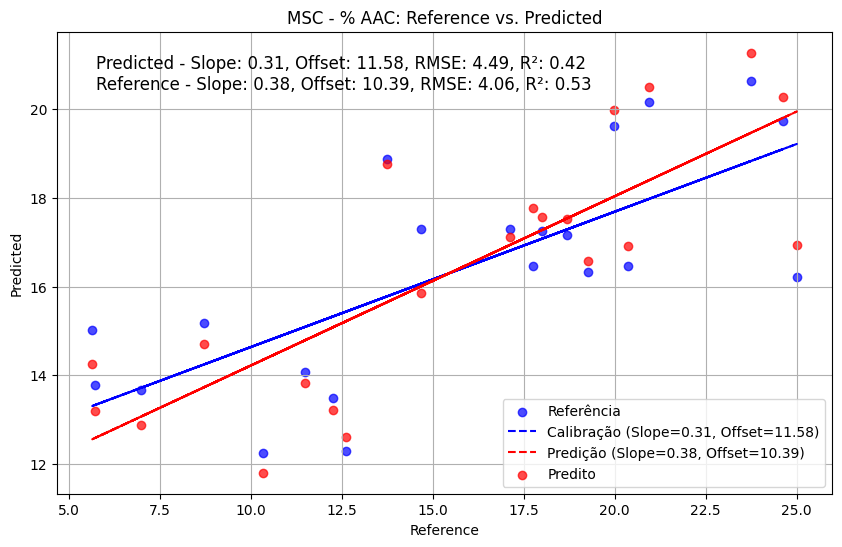

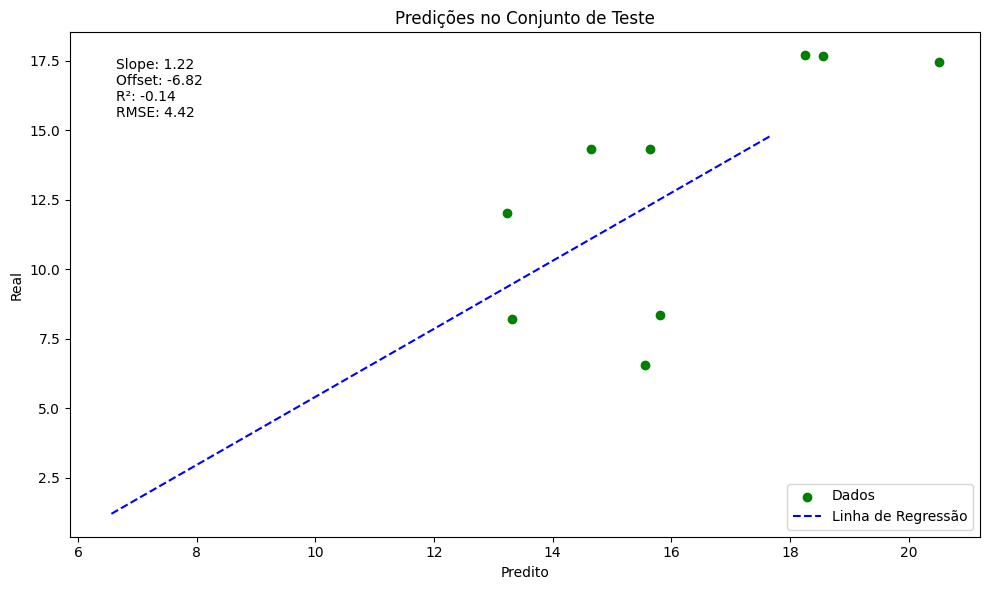

In [7]:
results_msc_sst = SVM(df_msc_cal.iloc[:, 7:], df_msc_cal['% AAC'].values, df_msc_val.iloc[:, 7:], df_msc_val['% AAC'].values, 'MSC', '% AAC')
infos_msc = add_plot_infos(infos_msc, results_msc_sst, '% AAC')

=== Training Metrics ===
R²: 0.9651
Correlation coefficient: 0.9840
RMSE: 0.0332
MAE: 0.0154
Relative absolute error: 9.5845
Root relative squared error: 18.6882
Slope: 1.0587
Offset: -0.0238
=== Cross-Validation Metrics ===
R²: 0.6671
Correlation coefficient: 0.8273
RMSE: 0.1025
MAE: 0.0836
Relative absolute error: 52.0623
Root relative squared error: 57.6976
Slope: 0.8712
Offset: 0.0506
=== Validation Metrics ===
R²: -0.4128
Correlation coefficient: 0.5416
RMSE: 0.1589
MAE: 0.1303
Relative absolute error: 114.2351
Root relative squared error: 118.8623
Slope: 0.6120
Offset: 0.0642


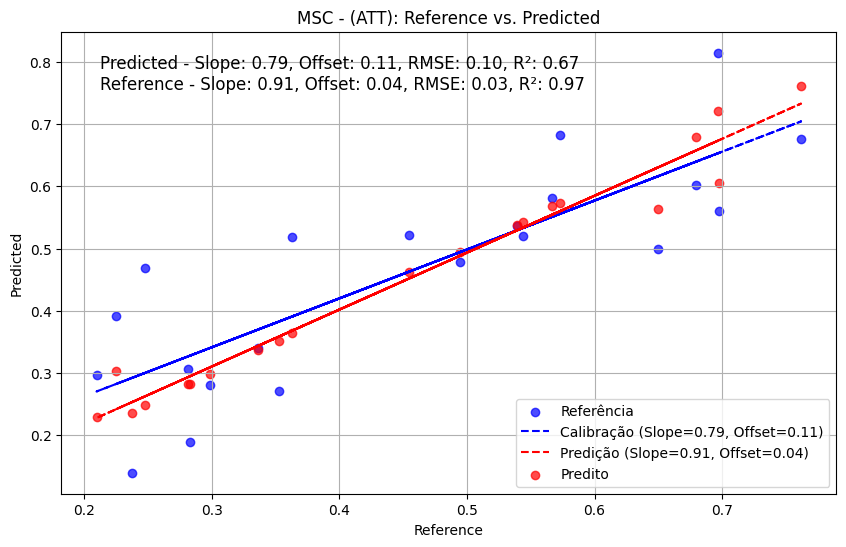

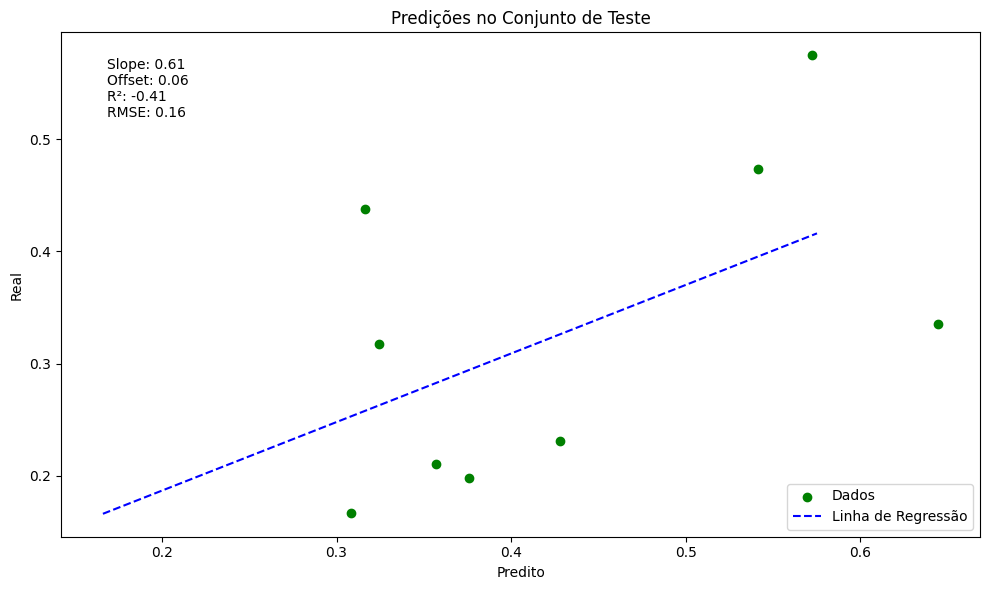

In [8]:
results_msc_sst = SVM(df_msc_cal.iloc[:, 7:], df_msc_cal['(ATT)'].values, df_msc_val.iloc[:, 7:], df_msc_val['(ATT)'].values, 'MSC', '(ATT)')
infos_msc = add_plot_infos(infos_msc, results_msc_sst, '(ATT)')

=== Training Metrics ===
R²: 0.9922
Correlation coefficient: 0.9970
RMSE: 0.0009
MAE: 0.0009
Relative absolute error: 10.4197
Root relative squared error: 8.8538
Slope: 1.0459
Offset: -0.0063
=== Cross-Validation Metrics ===
R²: 0.1977
Correlation coefficient: 0.5264
RMSE: 0.0096
MAE: 0.0067
Relative absolute error: 76.2339
Root relative squared error: 89.5737
Slope: 0.6558
Offset: 0.0471
=== Validation Metrics ===
R²: 0.2755
Correlation coefficient: 0.6403
RMSE: 0.0098
MAE: 0.0087
Relative absolute error: 91.0353
Root relative squared error: 85.1151
Slope: 0.6944
Offset: 0.0382


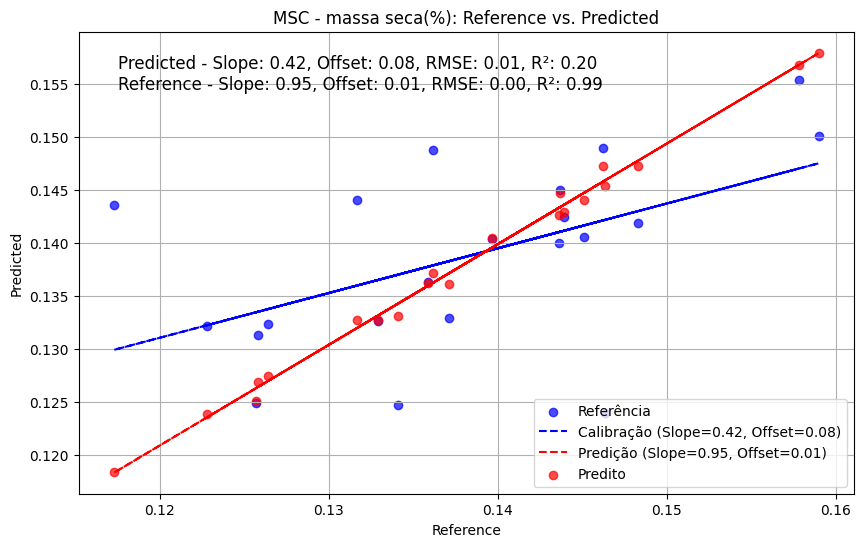

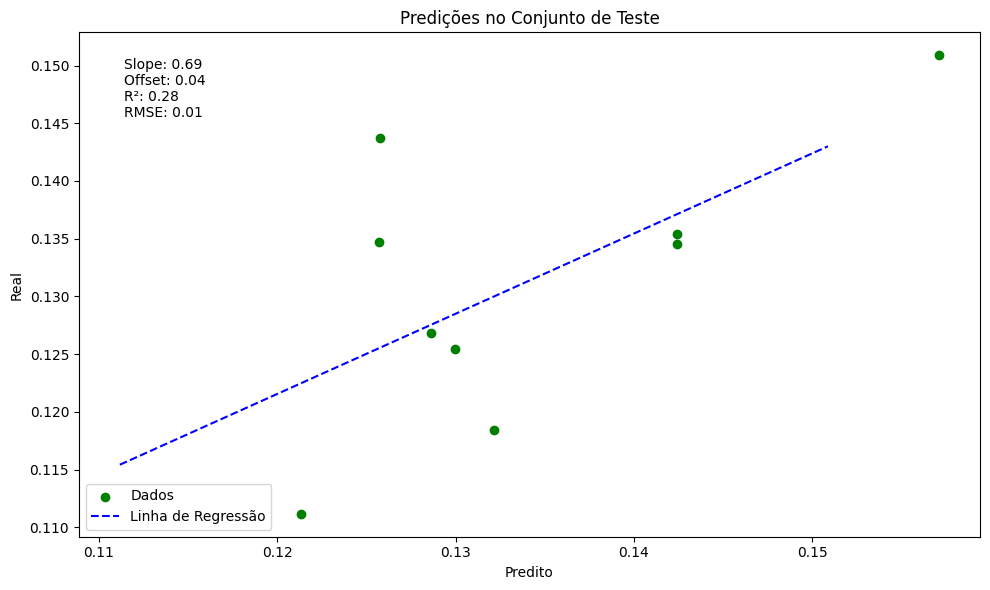

In [9]:
results_msc_sst = SVM(df_msc_cal.iloc[:, 7:], df_msc_cal['massa seca(%)'].values, df_msc_val.iloc[:, 7:], df_msc_val['massa seca(%)'].values, 'MSC', 'massa seca(%)')
infos_msc = add_plot_infos(infos_msc, results_msc_sst, 'massa seca(%)')

In [10]:
infos_msc.to_excel('plot_infos_SVM_msc.xlsx', index=False)
infos_msc

,Attribute,Y,R²,Correlation coefficient,RMSE,MAE,Relative absolute error,Root relative squared error,Slope,Offset
0,BRIX,Training,0.229379,0.523804,1.509003,0.956687,72.516138,87.785017,1.246843,-2.956109
1,BRIX,Cross-Validation,-0.058322,0.150476,1.768391,1.381624,104.726032,102.874758,0.367100,6.488815
2,BRIX,Validation,0.341687,0.599970,0.535398,0.465495,77.423222,81.136489,0.866360,1.381775
3,FIRMNESS,Training,-0.321069,0.839899,60.682039,44.363452,85.457654,114.937787,13.626575,-1298.574082
4,FIRMNESS,Cross-Validation,-0.363917,0.626593,61.658260,45.542394,87.728660,116.786845,12.983131,-1234.810441
5,FIRMNESS,Validation,-1.552671,0.905147,75.840175,62.805181,140.343289,159.770811,16.121682,-1570.168396
6,% AAC,Training,0.525293,0.809507,4.059142,2.946148,57.474718,68.898962,1.713856,-12.429883
7,% AAC,Cross-Validation,0.419014,0.727514,4.490602,3.465257,67.601734,76.222466,1.731560,-12.698131
8,% AAC,Validation,-0.142495,0.688655,4.420459,3.205913,86.580996,106.887572,1.223390,-6.817569
9,(ATT),Training,0.965075,0.984001,0.033204,0.015383,9.584526,18.688178,1.058711,-0.023844


=== Training Metrics ===
R²: 0.2308
Correlation coefficient: 0.5276
RMSE: 1.5076
MAE: 0.9542
Relative absolute error: 72.3278
Root relative squared error: 87.7058
Slope: 1.2439
Offset: -2.9398
=== Cross-Validation Metrics ===
R²: -0.0651
Correlation coefficient: 0.1423
RMSE: 1.7740
MAE: 1.3897
Relative absolute error: 105.3366
Root relative squared error: 103.2039
Slope: 0.3481
Offset: 6.6878
=== Validation Metrics ===
R²: 0.3345
Correlation coefficient: 0.5983
RMSE: 0.5383
MAE: 0.4659
Relative absolute error: 77.4834
Root relative squared error: 81.5776
Slope: 0.8481
Offset: 1.5736


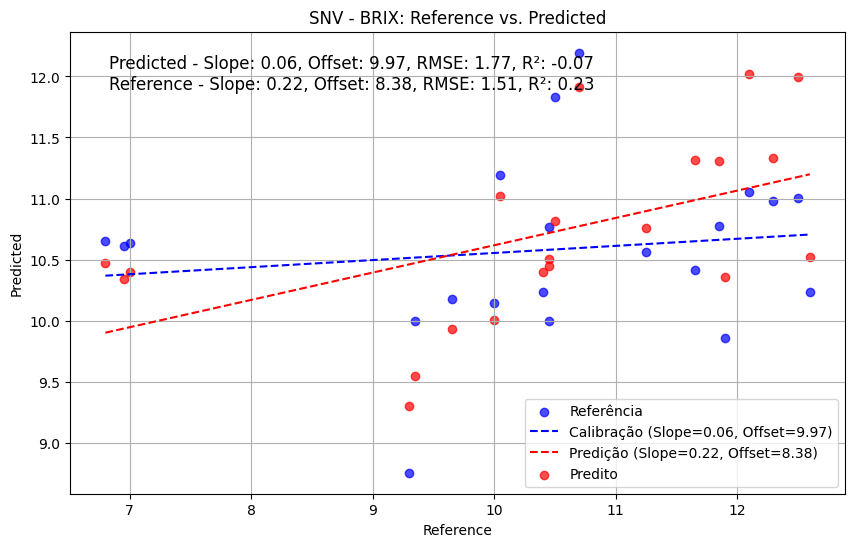

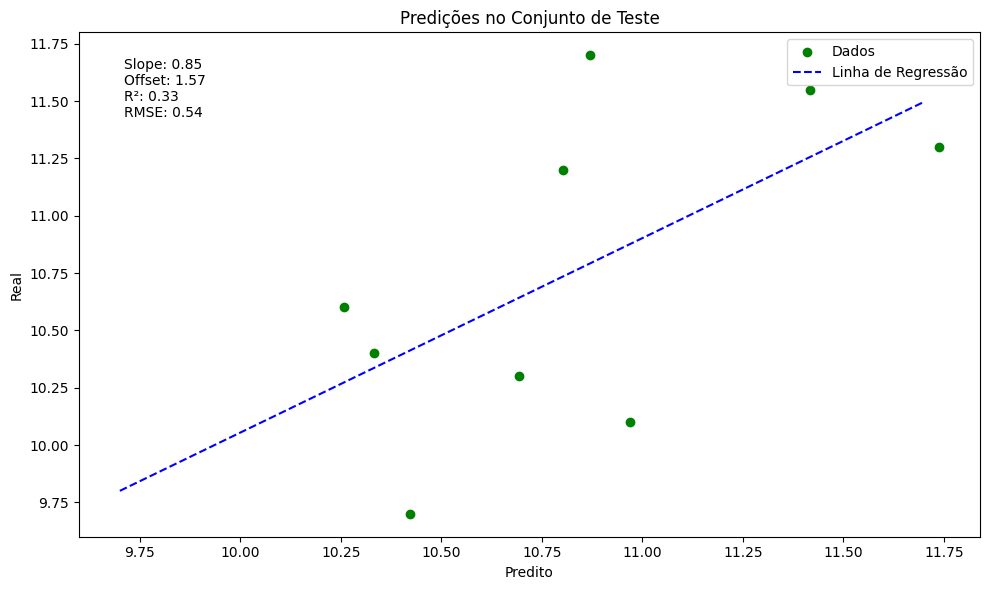

C:\Users\lenau\AppData\Local\Temp\ipykernel_9300\2636434218.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)


In [11]:
results_snv_sst = SVM(df_snv_cal.iloc[:, 7:], df_snv_cal['BRIX'].values, df_snv_val.iloc[:, 7:], df_snv_val['BRIX'].values, 'SNV', 'BRIX')
infos_snv = add_plot_infos(infos_snv, results_snv_sst, 'BRIX')

=== Training Metrics ===
R²: -0.3169
Correlation coefficient: 0.8425
RMSE: 60.5855
MAE: 44.3219
Relative absolute error: 85.3777
Root relative squared error: 114.7550
Slope: 13.4942
Offset: -1283.8637
=== Cross-Validation Metrics ===
R²: -0.3608
Correlation coefficient: 0.6441
RMSE: 61.5876
MAE: 45.4840
Relative absolute error: 87.6161
Root relative squared error: 116.6531
Slope: 13.1973
Offset: -1255.8405
=== Validation Metrics ===
R²: -1.5436
Correlation coefficient: 0.9078
RMSE: 75.7049
MAE: 62.7102
Relative absolute error: 140.1310
Root relative squared error: 159.4859
Slope: 15.8533
Offset: -1541.3636


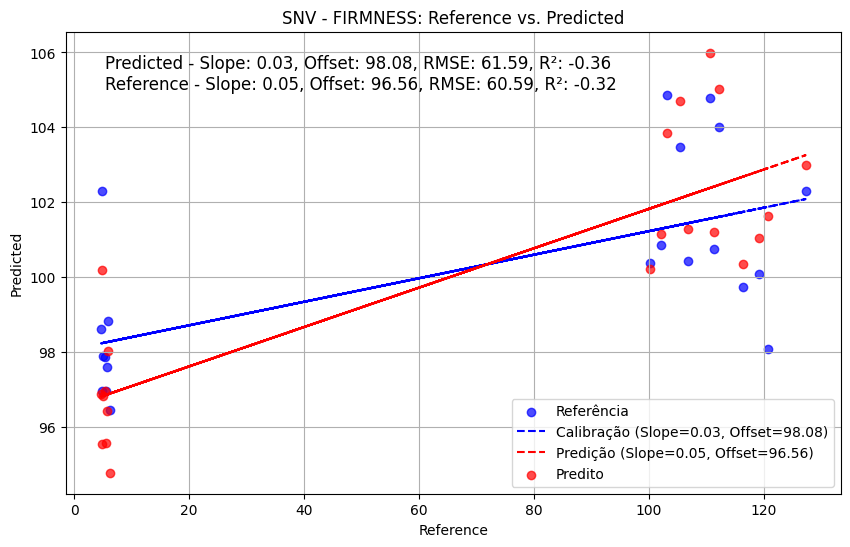

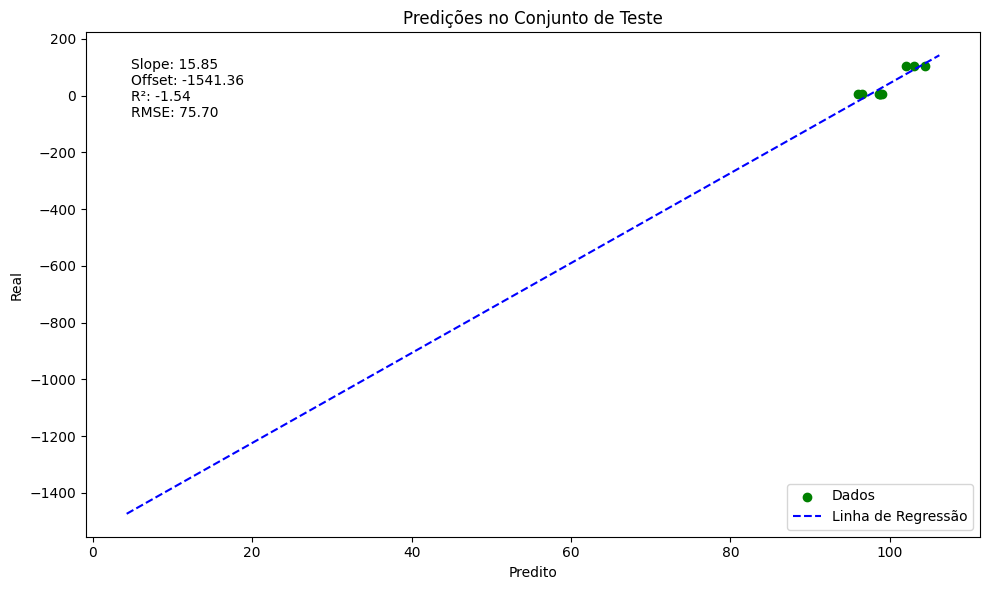

In [12]:
results_snv_sst = SVM(df_snv_cal.iloc[:, 7:], df_snv_cal['FIRMNESS'].values, df_snv_val.iloc[:, 7:], df_snv_val['FIRMNESS'].values, 'SNV', 'FIRMNESS')
infos_snv = add_plot_infos(infos_snv, results_snv_sst, 'FIRMNESS')

=== Training Metrics ===
R²: 0.5235
Correlation coefficient: 0.8104
RMSE: 4.0667
MAE: 2.9409
Relative absolute error: 57.3729
Root relative squared error: 69.0274
Slope: 1.7212
Offset: -12.6131
=== Cross-Validation Metrics ===
R²: 0.4164
Correlation coefficient: 0.7274
RMSE: 4.5006
MAE: 3.4669
Relative absolute error: 67.6334
Root relative squared error: 76.3923
Slope: 1.7368
Offset: -12.8514
=== Validation Metrics ===
R²: -0.1556
Correlation coefficient: 0.6866
RMSE: 4.4458
MAE: 3.2377
Relative absolute error: 87.4393
Root relative squared error: 107.4992
Slope: 1.2093
Offset: -6.6282


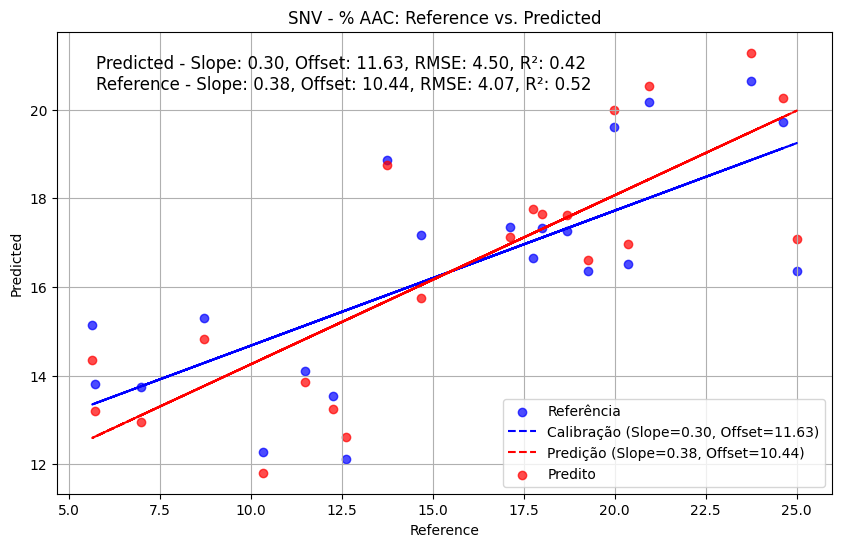

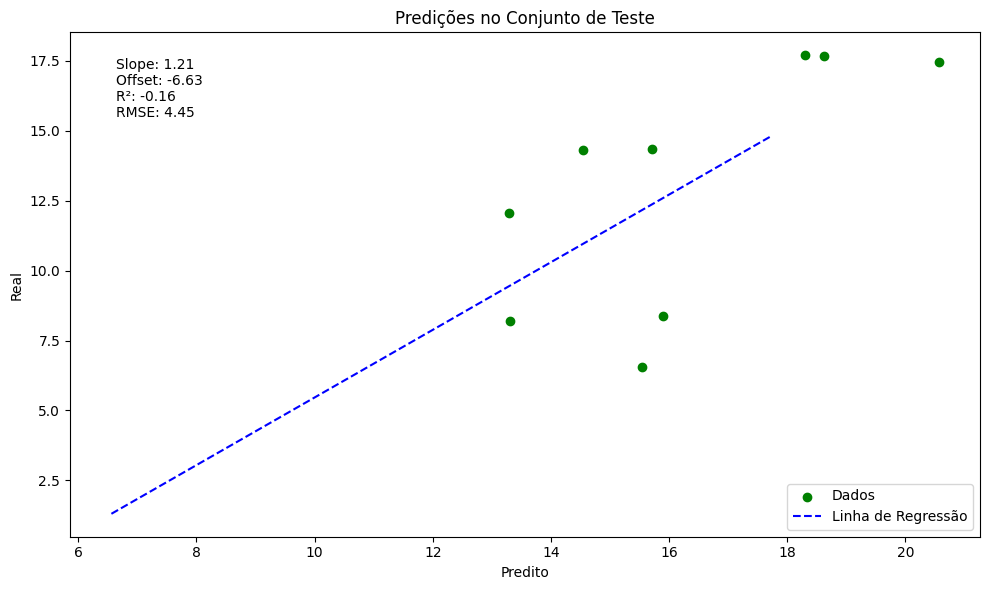

In [13]:
results_snv_sst = SVM(df_snv_cal.iloc[:, 7:], df_snv_cal['% AAC'].values, df_snv_val.iloc[:, 7:], df_snv_val['% AAC'].values, 'SNV', '% AAC')
infos_snv = add_plot_infos(infos_snv, results_snv_sst, '% AAC')

=== Training Metrics ===
R²: 0.9646
Correlation coefficient: 0.9837
RMSE: 0.0334
MAE: 0.0155
Relative absolute error: 9.6803
Root relative squared error: 18.8125
Slope: 1.0583
Offset: -0.0238
=== Cross-Validation Metrics ===
R²: 0.6674
Correlation coefficient: 0.8271
RMSE: 0.1025
MAE: 0.0832
Relative absolute error: 51.8278
Root relative squared error: 57.6735
Slope: 0.8730
Offset: 0.0499
=== Validation Metrics ===
R²: -0.4023
Correlation coefficient: 0.5448
RMSE: 0.1583
MAE: 0.1293
Relative absolute error: 113.4203
Root relative squared error: 118.4171
Slope: 0.6105
Offset: 0.0654


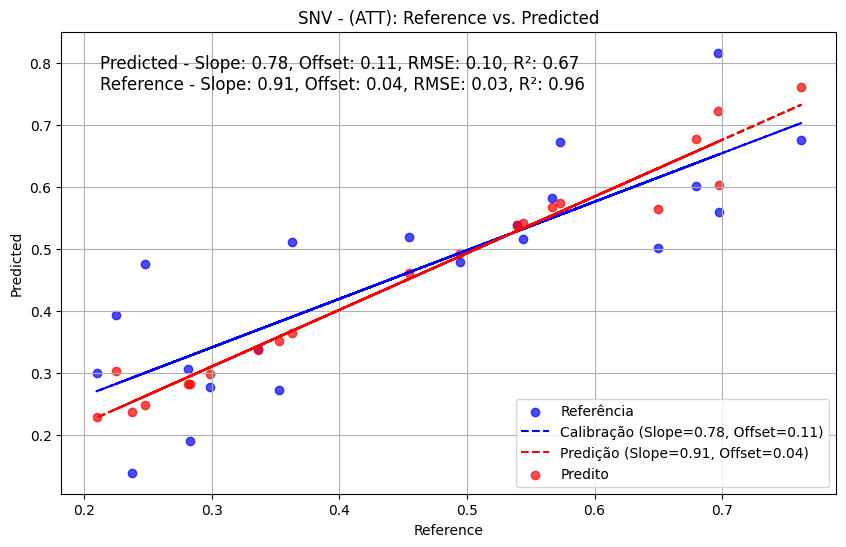

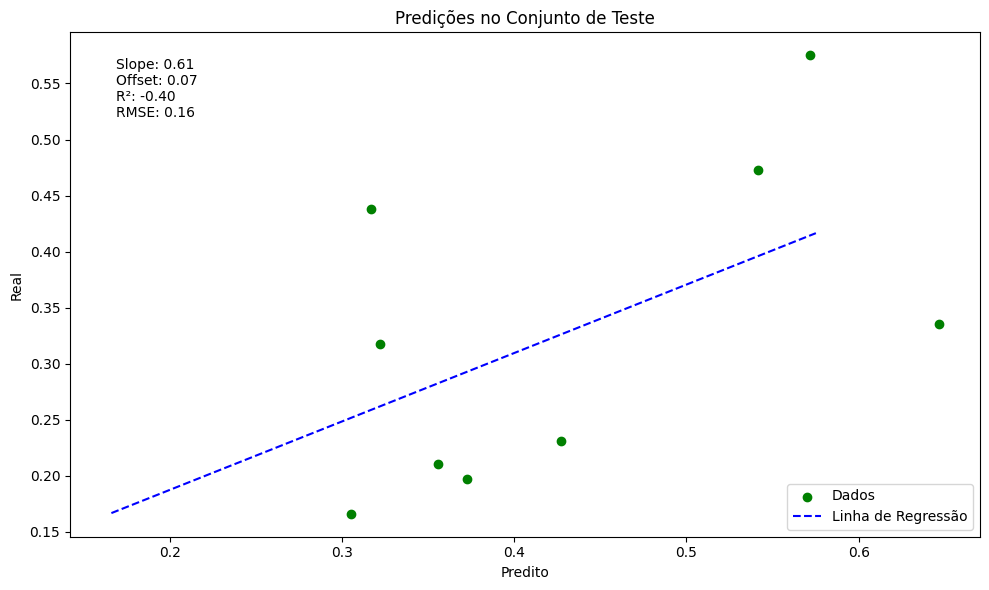

In [14]:
results_snv_sst = SVM(df_snv_cal.iloc[:, 7:], df_snv_cal['(ATT)'].values, df_snv_val.iloc[:, 7:], df_snv_val['(ATT)'].values, 'SNV', '(ATT)')
infos_snv = add_plot_infos(infos_snv, results_snv_sst, '(ATT)')

=== Training Metrics ===
R²: 0.9922
Correlation coefficient: 0.9970
RMSE: 0.0009
MAE: 0.0009
Relative absolute error: 10.4886
Root relative squared error: 8.8530
Slope: 1.0435
Offset: -0.0059
=== Cross-Validation Metrics ===
R²: 0.1906
Correlation coefficient: 0.5234
RMSE: 0.0096
MAE: 0.0068
Relative absolute error: 76.6534
Root relative squared error: 89.9650
Slope: 0.6489
Offset: 0.0481
=== Validation Metrics ===
R²: 0.2837
Correlation coefficient: 0.6456
RMSE: 0.0098
MAE: 0.0086
Relative absolute error: 90.2771
Root relative squared error: 84.6375
Slope: 0.6956
Offset: 0.0381


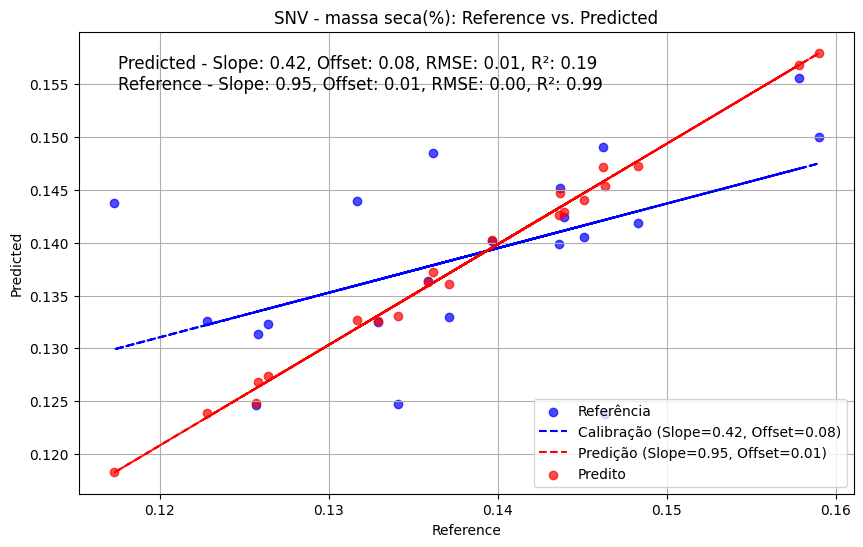

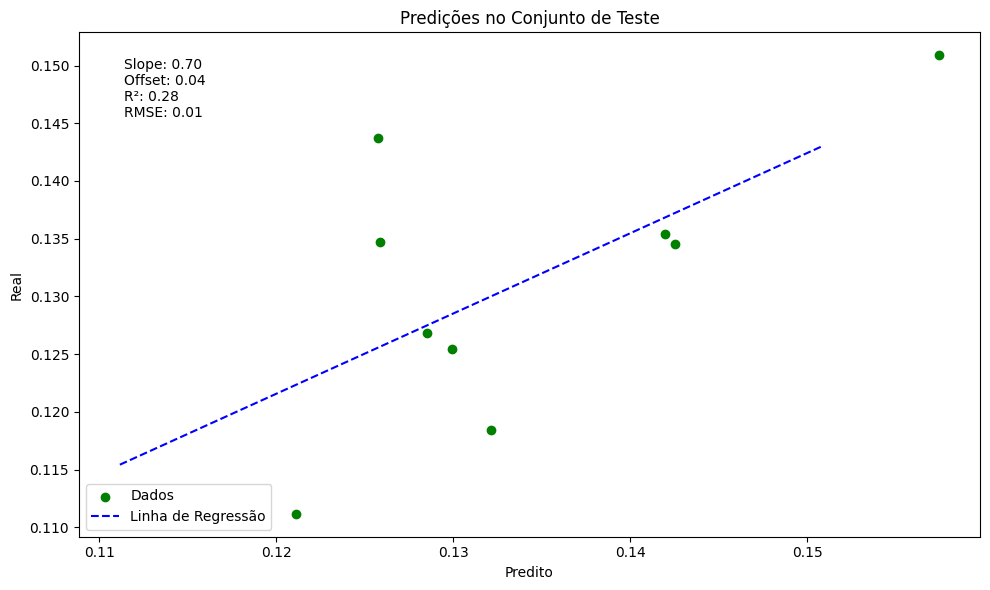

In [15]:
results_snv_sst = SVM(df_snv_cal.iloc[:, 7:], df_snv_cal['massa seca(%)'].values, df_snv_val.iloc[:, 7:], df_snv_val['massa seca(%)'].values, 'SNV', 'massa seca(%)')
infos_snv = add_plot_infos(infos_snv, results_snv_sst, 'massa seca(%)')

In [16]:
infos_snv.to_excel('plot_infos_SVM_snv.xlsx', index=False)
infos_snv

,Attribute,Y,R²,Correlation coefficient,RMSE,MAE,Relative absolute error,Root relative squared error,Slope,Offset
0,BRIX,Training,0.230769,0.527622,1.507641,0.954202,72.327780,87.705810,1.243900,-2.939827
1,BRIX,Cross-Validation,-0.065105,0.142254,1.774050,1.389679,105.336603,103.203917,0.348105,6.687791
2,BRIX,Validation,0.334509,0.598250,0.538309,0.465857,77.483354,81.577644,0.848094,1.573602
3,FIRMNESS,Training,-0.316871,0.842455,60.585547,44.321920,85.377650,114.755020,13.494183,-1283.863652
4,FIRMNESS,Cross-Validation,-0.360794,0.644098,61.587634,45.483952,87.616083,116.653073,13.197255,-1255.840495
5,FIRMNESS,Validation,-1.543576,0.907832,75.704949,62.710175,140.130990,159.485934,15.853290,-1541.363566
6,% AAC,Training,0.523521,0.810412,4.066711,2.940929,57.372920,69.027427,1.721250,-12.613141
7,% AAC,Cross-Validation,0.416422,0.727430,4.500606,3.466880,67.633399,76.392266,1.736779,-12.851410
8,% AAC,Validation,-0.155608,0.686597,4.445755,3.237694,87.439284,107.499222,1.209298,-6.628166
9,(ATT),Training,0.964609,0.983733,0.033425,0.015537,9.680343,18.812489,1.058315,-0.023814


=== Training Metrics ===
R²: 0.3847
Correlation coefficient: 0.6999
RMSE: 1.3483
MAE: 0.9462
Relative absolute error: 71.7211
Root relative squared error: 78.4392
Slope: 1.8400
Offset: -8.8850
=== Cross-Validation Metrics ===
R²: 0.0225
Correlation coefficient: 0.2075
RMSE: 1.6995
MAE: 1.4173
Relative absolute error: 107.4274
Root relative squared error: 98.8699
Slope: 0.6310
Offset: 3.7427
=== Validation Metrics ===
R²: -1.5357
Correlation coefficient: -0.7655
RMSE: 1.0508
MAE: 0.9798
Relative absolute error: 162.9604
Root relative squared error: 159.2403
Slope: -1.1092
Offset: 22.7370


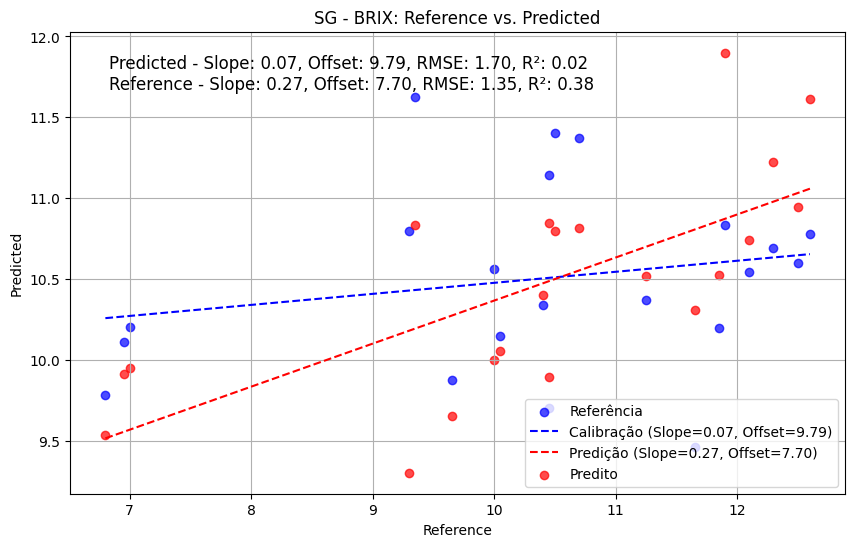

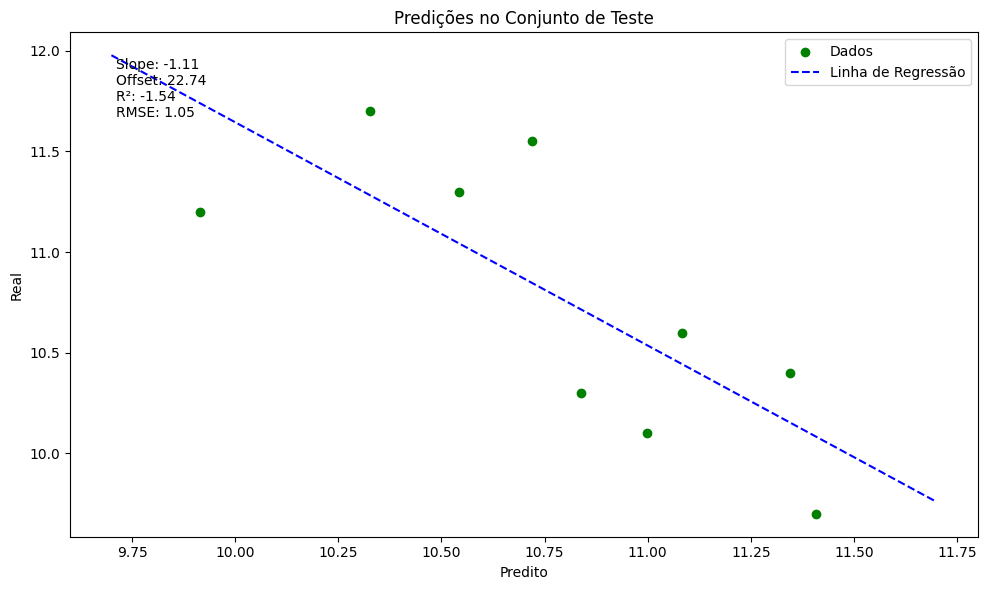

C:\Users\lenau\AppData\Local\Temp\ipykernel_9300\2636434218.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)


In [17]:
results_sg_sst = SVM(df_sg_cal.iloc[:, 7:], df_sg_cal['BRIX'].values, df_sg_val.iloc[:, 7:], df_sg_val['BRIX'].values, 'SG', 'BRIX')
infos_sg = add_plot_infos(infos_sg, results_sg_sst, 'BRIX')

=== Training Metrics ===
R²: -0.3379
Correlation coefficient: 0.6853
RMSE: 61.0680
MAE: 45.4091
Relative absolute error: 87.4718
Root relative squared error: 115.6689
Slope: 13.9842
Offset: -1323.9588
=== Cross-Validation Metrics ===
R²: -0.3993
Correlation coefficient: 0.1108
RMSE: 62.4520
MAE: 46.9587
Relative absolute error: 90.4568
Root relative squared error: 118.2903
Slope: 3.4701
Offset: -279.3734
=== Validation Metrics ===
R²: -1.5361
Correlation coefficient: 0.3764
RMSE: 75.5932
MAE: 63.9563
Relative absolute error: 142.9156
Root relative squared error: 159.2505
Slope: 11.4088
Offset: -1080.2894


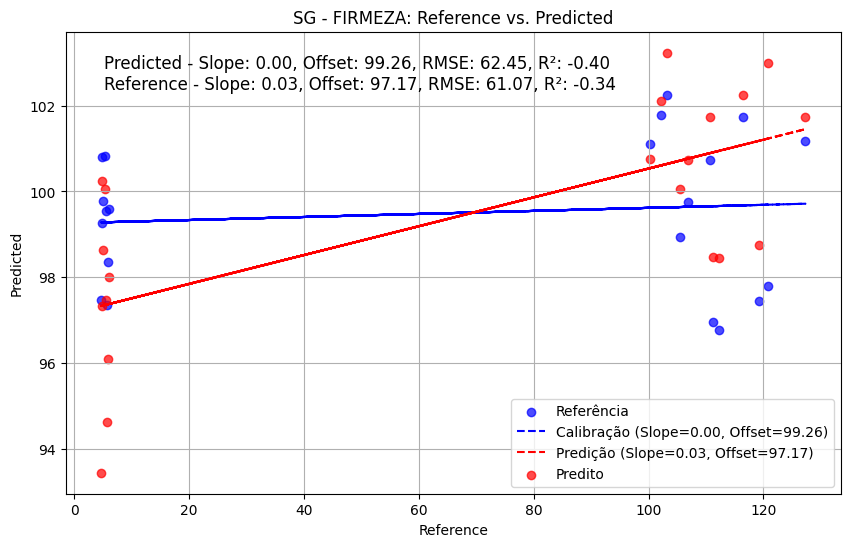

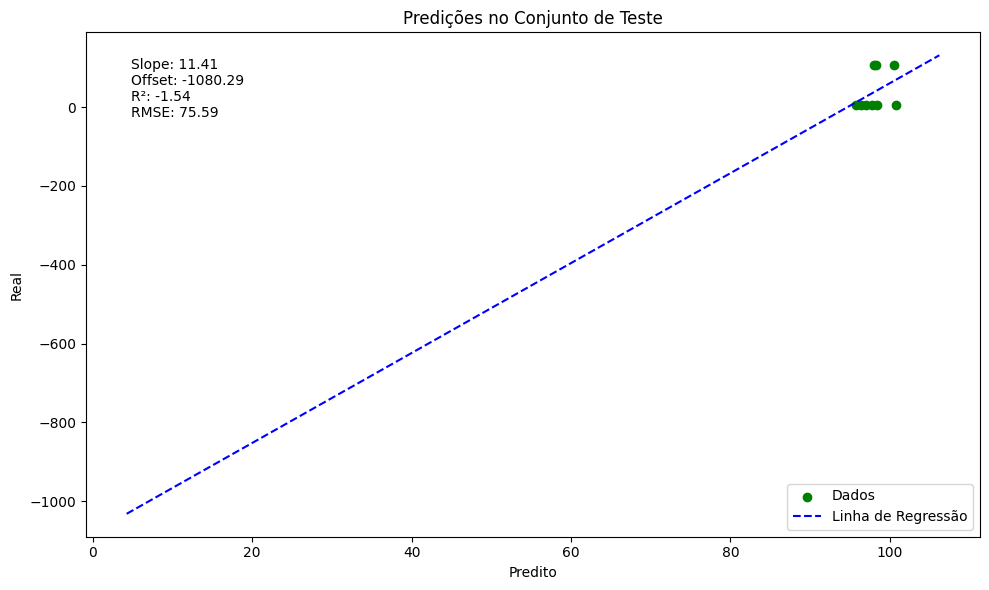

In [18]:
results_sg_sst = SVM(df_sg_cal.iloc[:, 7:], df_sg_cal['FIRMNESS'].values, df_sg_val.iloc[:, 7:], df_sg_val['FIRMNESS'].values, 'SG', 'FIRMEZA')
infos_sg = add_plot_infos(infos_sg, results_sg_sst, 'FIRMNESS')

=== Training Metrics ===
R²: 0.2873
Correlation coefficient: 0.6018
RMSE: 4.9736
MAE: 3.9212
Relative absolute error: 76.4959
Root relative squared error: 84.4204
Slope: 1.7850
Offset: -12.9806
=== Cross-Validation Metrics ===
R²: 0.1414
Correlation coefficient: 0.4088
RMSE: 5.4592
MAE: 4.5274
Relative absolute error: 88.3216
Root relative squared error: 92.6627
Slope: 1.5430
Offset: -9.1224
=== Validation Metrics ===
R²: -0.2652
Correlation coefficient: 0.1501
RMSE: 4.6518
MAE: 3.4966
Relative absolute error: 94.4327
Root relative squared error: 112.4822
Slope: 0.4799
Offset: 5.7272


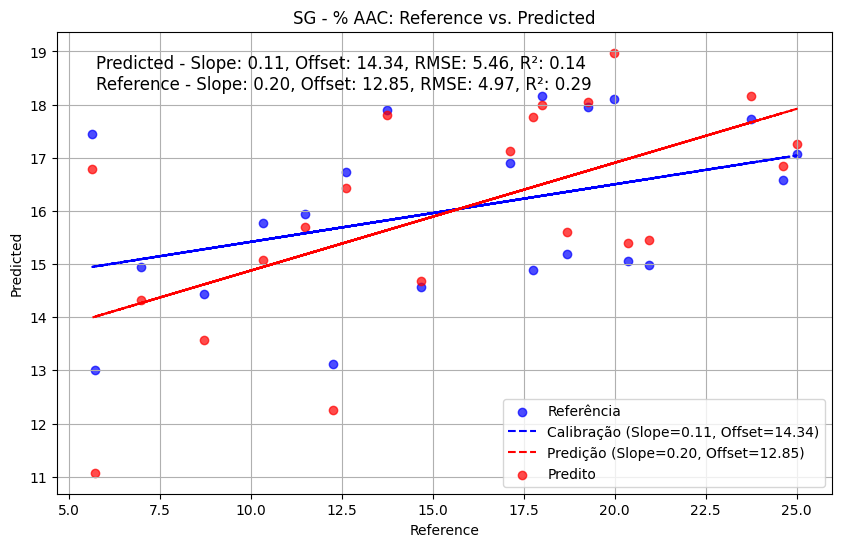

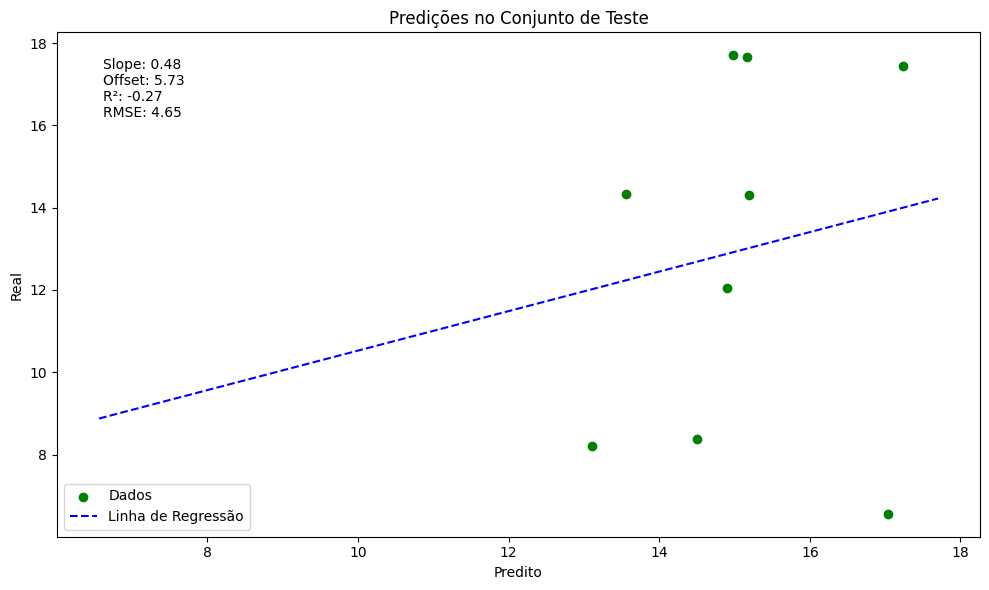

In [19]:
results_sg_sst = SVM(df_sg_cal.iloc[:, 7:], df_sg_cal['% AAC'].values, df_sg_val.iloc[:, 7:], df_sg_val['% AAC'].values, 'SG', '% AAC')
infos_sg = add_plot_infos(infos_sg, results_sg_sst, '% AAC')

=== Training Metrics ===
R²: 0.8905
Correlation coefficient: 0.9550
RMSE: 0.0588
MAE: 0.0334
Relative absolute error: 20.7808
Root relative squared error: 33.0945
Slope: 1.1807
Offset: -0.0790
=== Cross-Validation Metrics ===
R²: 0.5588
Correlation coefficient: 0.7557
RMSE: 0.1180
MAE: 0.0987
Relative absolute error: 61.4978
Root relative squared error: 66.4228
Slope: 0.9015
Offset: 0.0563
=== Validation Metrics ===
R²: -0.2820
Correlation coefficient: 0.5870
RMSE: 0.1514
MAE: 0.1305
Relative absolute error: 114.4727
Root relative squared error: 113.2250
Slope: 0.7380
Offset: 0.0104


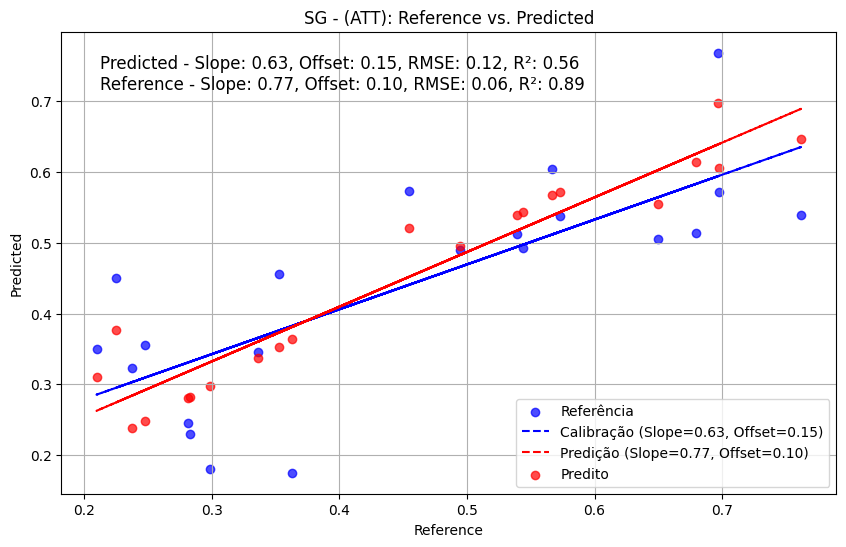

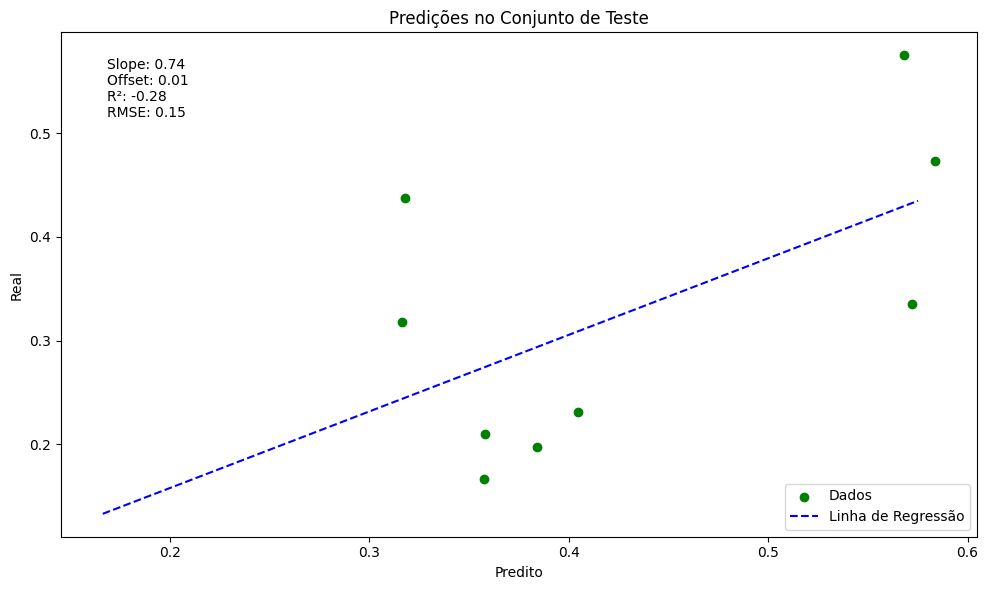

In [20]:
results_sg_sst = SVM(df_sg_cal.iloc[:, 7:], df_sg_cal['(ATT)'].values, df_sg_val.iloc[:, 7:], df_sg_val['(ATT)'].values, 'SG', '(ATT)')
infos_sg = add_plot_infos(infos_sg, results_sg_sst, '(ATT)')

=== Training Metrics ===
R²: 0.9918
Correlation coefficient: 0.9969
RMSE: 0.0010
MAE: 0.0010
Relative absolute error: 10.7810
Root relative squared error: 9.0329
Slope: 1.0466
Offset: -0.0065
=== Cross-Validation Metrics ===
R²: -0.6362
Correlation coefficient: 0.2788
RMSE: 0.0137
MAE: 0.0092
Relative absolute error: 104.4623
Root relative squared error: 127.9151
Slope: 0.2484
Offset: 0.1039
=== Validation Metrics ===
R²: 0.0573
Correlation coefficient: 0.6808
RMSE: 0.0112
MAE: 0.0097
Relative absolute error: 101.2545
Root relative squared error: 97.0926
Slope: 0.5454
Offset: 0.0578


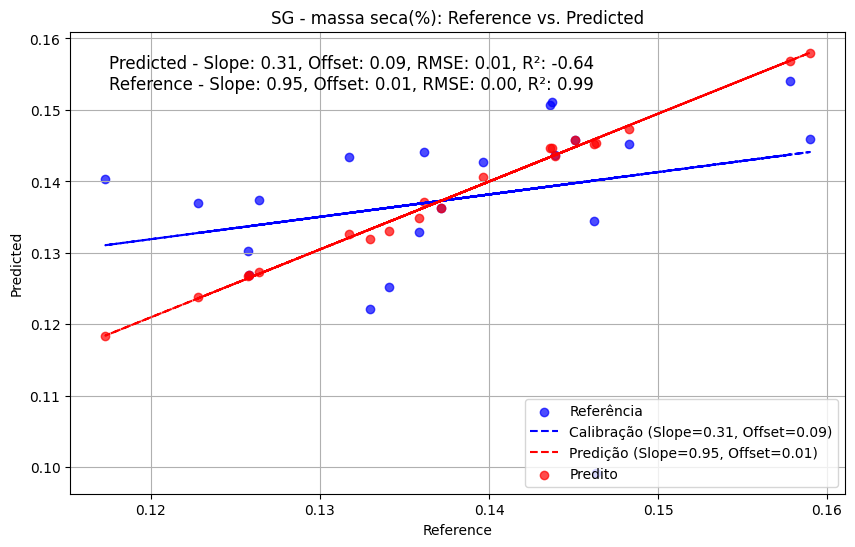

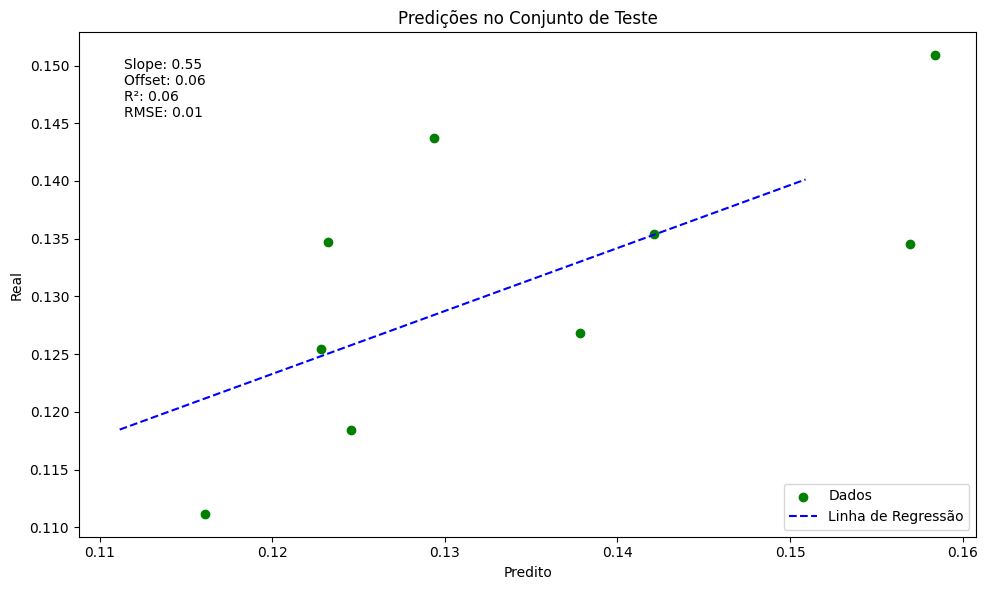

In [21]:
results_sg_sst = SVM(df_sg_cal.iloc[:, 7:], df_sg_cal['massa seca(%)'].values, df_sg_val.iloc[:, 7:], df_sg_val['massa seca(%)'].values, 'SG', 'massa seca(%)')
infos_sg = add_plot_infos(infos_sg, results_sg_sst, 'massa seca(%)')

In [22]:
infos_sg.to_excel('plot_infos_SVM_sg.xlsx', index=False)
infos_sg

,Attribute,Y,R²,Correlation coefficient,RMSE,MAE,Relative absolute error,Root relative squared error,Slope,Offset
0,BRIX,Training,0.384730,0.699915,1.348350,0.946198,71.721121,78.439158,1.840036,-8.885036
1,BRIX,Cross-Validation,0.022474,0.207548,1.699549,1.417262,107.427391,98.869901,0.631033,3.742698
2,BRIX,Validation,-1.535748,-0.765490,1.050784,0.979774,162.960421,159.240336,-1.109213,22.737039
3,FIRMNESS,Training,-0.337930,0.685286,61.068036,45.409067,87.471831,115.668903,13.984173,-1323.958829
4,FIRMNESS,Cross-Validation,-0.399260,0.110823,62.452037,46.958666,90.456834,118.290337,3.470063,-279.373352
5,FIRMNESS,Validation,-1.536071,0.376417,75.593182,63.956302,142.915561,159.250477,11.408763,-1080.289357
6,% AAC,Training,0.287319,0.601826,4.973580,3.921169,76.495866,84.420419,1.784985,-12.980578
7,% AAC,Cross-Validation,0.141363,0.408840,5.459167,4.527354,88.321577,92.662670,1.543031,-9.122445
8,% AAC,Validation,-0.265224,0.150087,4.651830,3.496645,94.432672,112.482161,0.479877,5.727172
9,(ATT),Training,0.890476,0.954982,0.058801,0.033354,20.780835,33.094465,1.180667,-0.078999
